# Imports and configuration

In [677]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import axes3d
from xgboost import XGBClassifier
from datetime import date
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, confusion_matrix, f1_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA

# Will allow us to embed images in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 3)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

r = 666
np.random.seed(r)

# Loading original dataset

In [678]:
dataset = pd.read_csv("../common/dataset.csv", header=0, index_col='CUST_COD')
# Backup original dataset
orig_dataset = dataset.copy()

print(orig_dataset.shape)

(26884, 24)


In [679]:
orig_dataset.head(5)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,BIRTH_DATE,PAY_DEC,PAY_NOV,PAY_OCT,PAY_SEP,PAY_AUG,...,BILL_AMT_SEP,BILL_AMT_AUG,BILL_AMT_JUL,PAY_AMT_DEC,PAY_AMT_NOV,PAY_AMT_OCT,PAY_AMT_SEP,PAY_AMT_AUG,PAY_AMT_JUL,DEFAULT PAYMENT JAN
CUST_COD,,,,,,,,,,,,,,,,,,,,,
53613503,1490.680,M,university,single,NaN,0,0,0,0,2,...,629.156401,599.283174,608.257067,89.440800,149.06800,68.571280,0.000000,29.81360,59.627200,0
35524089,5664.584,M,university,married,04/01/1983,0,0,0,0,0,...,533.872135,-2.772665,-14.399969,149.068000,159.83071,29.813600,0.000000,0.00000,0.000000,1
58777007,6260.856,F,high school,married,02/01/1975,0,0,-1,-1,-2,...,-19.349026,-19.349026,-19.349026,59.627200,532.59015,16.963938,0.000000,0.00000,29.813600,0
26913418,8944.080,F,graduate school,married,15/01/1977,-2,-2,-2,-2,-2,...,88.546392,70.330282,253.177091,80.556347,217.22189,88.784901,70.628418,298.46395,216.416922,0
41993633,3577.632,F,graduate school,married,09/01/1978,-1,-1,-1,-1,-1,...,0.000000,569.439760,0.000000,119.254400,29.81360,0.000000,569.439760,0.00000,0.000000,1


In [680]:
orig_dataset.describe()

,LIMIT_BAL,PAY_DEC,PAY_NOV,PAY_OCT,PAY_SEP,PAY_AUG,PAY_JUL,BILL_AMT_DEC,BILL_AMT_NOV,BILL_AMT_OCT,BILL_AMT_SEP,BILL_AMT_AUG,BILL_AMT_JUL,PAY_AMT_DEC,PAY_AMT_NOV,PAY_AMT_OCT,PAY_AMT_SEP,PAY_AMT_AUG,PAY_AMT_JUL,DEFAULT PAYMENT JAN
count,26884.00000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000
mean,4997.91411,-0.016367,-0.133313,-0.166344,-0.219052,-0.264879,-0.291884,1530.136656,1467.012379,1404.166272,1292.346498,1203.977907,1159.529034,168.639427,178.825861,156.416357,144.518815,144.259750,157.534344,0.221098
std,3879.73624,1.123991,1.197715,1.197837,1.171221,1.135089,1.150547,2206.111841,2129.923058,2072.220534,1923.241494,1816.137779,1775.876050,495.392694,688.001298,531.588567,465.903631,463.780141,538.637089,0.414994
min,298.13600,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-4936.535888,-2080.303567,-4688.605990,-2424.859342,-2424.859342,-10124.788000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1490.68000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,105.115300,87.622170,79.535231,68.951403,52.553923,37.594950,29.634718,24.879449,11.627304,8.884453,7.870790,3.637259,0.000000
50%,4173.90400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,667.198554,631.705464,599.491869,568.008707,539.998830,506.920641,62.608560,60.044590,54.260752,44.720400,44.720400,44.720400,0.000000
75%,7155.26400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1997.891324,1905.320095,1798.386166,1629.998953,1504.528417,1473.179417,149.276695,149.068000,134.369895,119.709057,120.379863,119.321481,0.000000
max,29813.60000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,28755.545150,29334.525260,49612.483810,26581.388370,27642.305330,28670.665830,26043.729910,50213.824120,26714.178140,18514.245600,12716.364990,15761.436660,1.000000


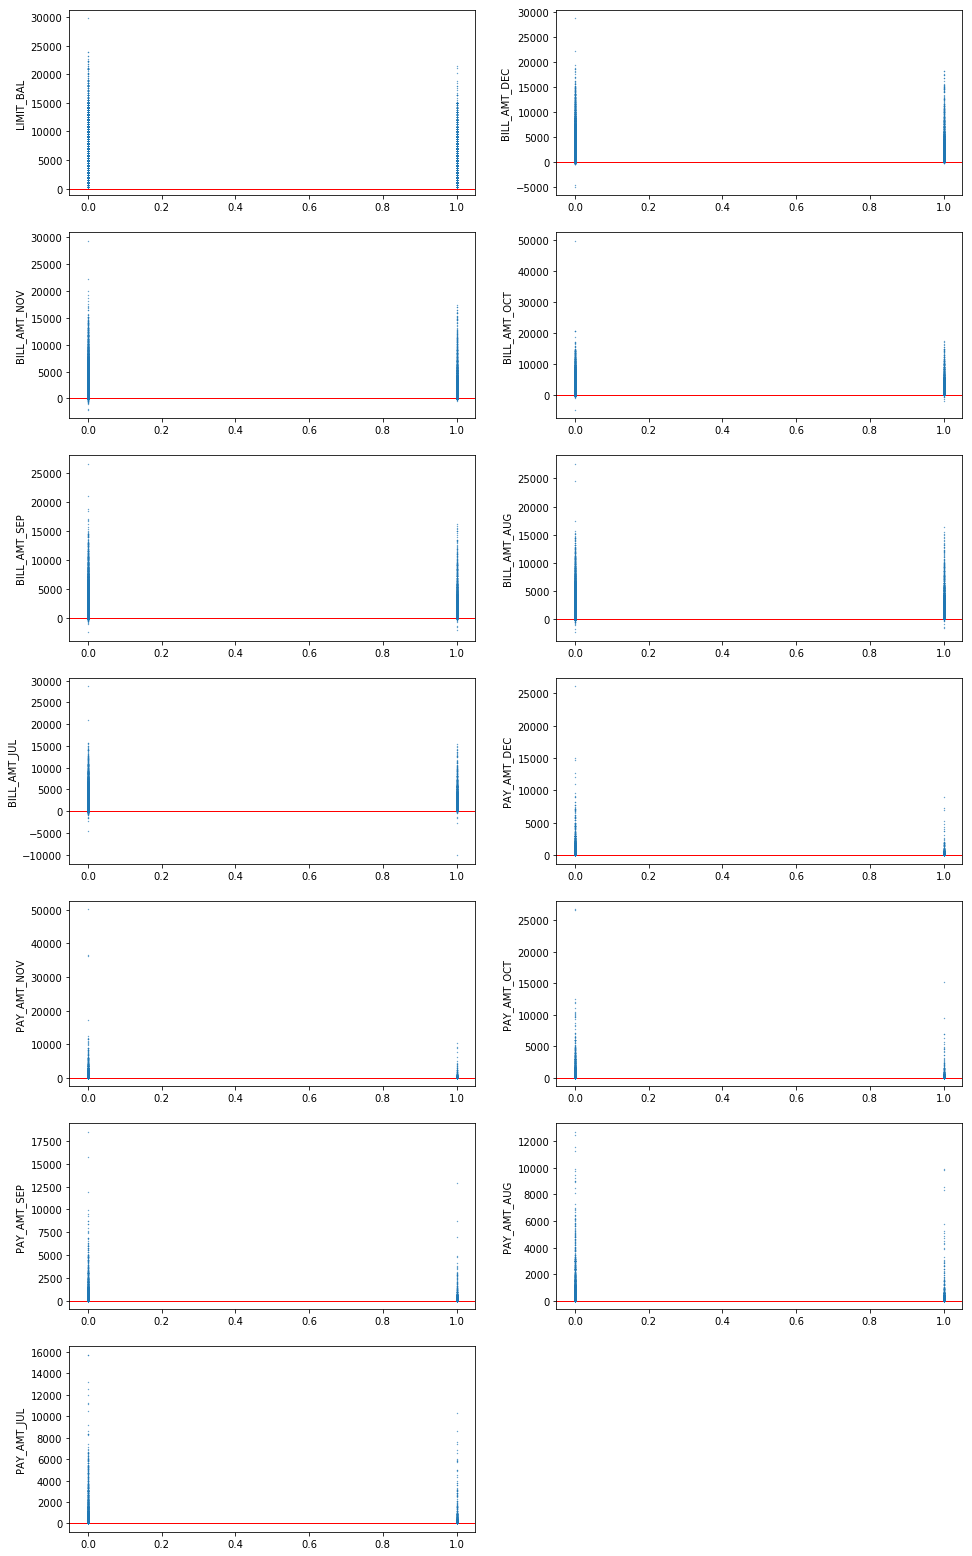

In [681]:
fig = plt.figure(figsize=(16, 7 * 4))
fields = ['LIMIT_BAL',
              'BILL_AMT_DEC', 'BILL_AMT_NOV', 'BILL_AMT_OCT', 'BILL_AMT_SEP', 'BILL_AMT_AUG', 'BILL_AMT_JUL',
              'PAY_AMT_DEC', 'PAY_AMT_NOV', 'PAY_AMT_OCT', 'PAY_AMT_SEP', 'PAY_AMT_AUG', 'PAY_AMT_JUL']
# 13 fields
i = 1
for col_name in fields:
    ax = fig.add_subplot(7,2,i)
    i += 1
    ax.set_ylabel(col_name)
    ax.scatter(orig_dataset['DEFAULT PAYMENT JAN'], orig_dataset[col_name], s=0.1)
    ax.axhline(y=0, c='red', linewidth=1, zorder=0)
plt.show() 

               0     1
PAY_AUG_0  12307  2870
PAY_JUL_0  11834  2747
PAY_SEP_0  12022  2707
PAY_OCT_0  11624  2476
PAY_NOV_0  11825  2252


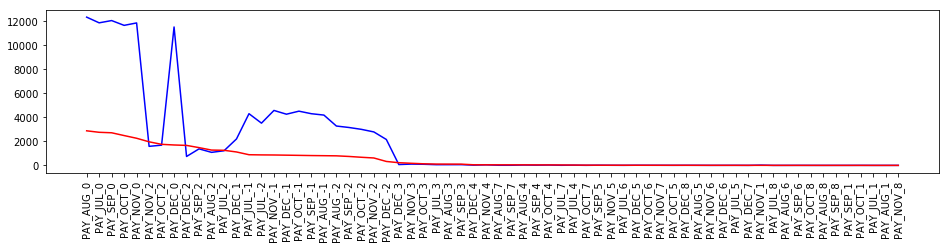

In [682]:
fields = ['PAY_DEC', 'PAY_NOV', 'PAY_OCT', 'PAY_SEP', 'PAY_AUG', 'PAY_JUL']
df = pd.DataFrame()
for field in fields:
    for j in [0]:
        for i in np.arange(-2,9):
            df['{}_{}'.format(field, i, j)] = (orig_dataset[field] == i) & (orig_dataset['DEFAULT PAYMENT JAN'] == j)
df1 = pd.DataFrame(df.sum())

df2 = pd.DataFrame()
for field in fields:
    for j in [1]:
        for i in np.arange(-2,9):
            df2['{}_{}'.format(field, i, j)] = (orig_dataset[field] == i) & (orig_dataset['DEFAULT PAYMENT JAN'] == j)
df3 = pd.DataFrame(df2.sum())
df3.rename(columns={0: 1}, inplace=True)

df4 = pd.concat([df1, df3], axis=1).sort_values([1], ascending = 0)
df4 = df4.sort_values([1], ascending = 0)

print(df4.head(5))
fig = plt.figure(figsize=(16, 3))
plt.plot(df4[0].tolist(), c='b')
plt.plot(df4[1].tolist(), c='r')
plt.xticks(np.arange(0, df4[0].size), df4.index, rotation='vertical')
plt.show()

# Different datasets management
- split_and_add
- add_dataset
- retrieve_dataset

In [737]:
# Format: {'name' : X_name}
X_dict = {}
# Format: {'name' : y_name}
y_dict = {}
# Format: {'name' : X_test_name}
X_test_dict = {}
# Format: {'name' : y_test_name}
y_test_dict = {}

names = set()
target_col_name = 'DEFAULT PAYMENT JAN'

def split_and_add(dataset, name):
    train, test = train_test_split(dataset, test_size=0.33, random_state=r, stratify=dataset[target_col_name])
    X = train.drop([target_col_name], 1)
    y = train[target_col_name]
    X_test = test.drop([target_col_name], 1)
    y_test = test[target_col_name]
    add_dataset(X, y, X_test, y_test, name)
    print('Train X shape: {}'.format(X.shape))
    print('Test X shape: {}'.format(X_test.shape))

def add_dataset(X, y, X_test, y_test, name):
    names.add(name)
    X_dict[name] = X
    y_dict[name] = y
    X_test_dict[name] = X_test
    y_test_dict[name] = y_test

def retrieve_dataset(name):
    return (X_dict[name], y_dict[name], X_test_dict[name], y_test_dict[name])

split_and_add(dataset=orig_dataset, name='orig')
split_and_add(dataset=orig_dataset.drop(['SEX', 'EDUCATION', 'MARRIAGE', 'BIRTH_DATE'], 1), name='baseline')
X, y, X_test, y_test = retrieve_dataset('baseline')
rs = RobustScaler()
rs.fit(X)
X = rs.transform(X)
X_test = rs.transform(X_test)
add_dataset(X, y, X_test, y_test, 'baseline_scaled')

Train X shape: (18012, 23)
Test X shape: (8872, 23)
Train X shape: (18012, 19)
Test X shape: (8872, 19)


# Alessandro's dataset
- One hot encoding of SEX
- scores to MARRIAGE and EDUCATION
- BIRTH_DATE transformed to AGE and normalized
- Columns with money values like LIMIT_BAL and BILL_AMT_DEC normalized togheter to mean=0 std=1
- Delay in payments normalized togheter to mean=0 std=1

In [738]:
def transform_features(X_orig):
    X = X_orig.copy()
    # print('One hot encoding SEX feature')
    # set(dataset["SEX"]) = {nan, 'M', 'F'}
    fields = {'SEX'}
    for field in fields:
        X = pd.concat([X.drop([field], 1), pd.get_dummies(X[field])], axis=1)

    # print('Scoring EDUCATION and MARRIAGE features')
    # Assume other == Nan
    # set(dataset["EDUCATION"]) = {nan, 'high school', 'graduate school', 'other§', 'university'}
    # set(dataset["MARRIAGE"]) = {nan, 'other', 'single', 'married'}
    education_dict = { 'other': 0, 'high school': 0.1, 'university': 0.5, 'graduate school': 1}
    marriage_dict = {'other': 0, 'single': 0.1, 'married': 1}
    X['EDUCATION'] = X['EDUCATION'].fillna('other').apply(lambda x: education_dict[x])
    X['MARRIAGE'] = X['MARRIAGE'].fillna('other').apply(lambda x: marriage_dict[x])

    # print('Computing AGE and dropping BIRTH_DATE')
    X['BIRTH_DATE'] = pd.to_datetime(X['BIRTH_DATE'], format='%d/%m/%Y')
    def calculate_age(birth_date):
        today = date.today()
        age = today.year - birth_date.year
        full_year_passed = (today.month, today.day) < (birth_date.month, birth_date.day)
        if not full_year_passed:
            age -= 1
        return age
    X['AGE'] = X['BIRTH_DATE'].apply(lambda x: calculate_age(x))
    X = X.drop(["BIRTH_DATE"], 1)
    X['AGE'] = X['AGE'].fillna(X['AGE'].median())

    fields = ['LIMIT_BAL',
              'BILL_AMT_DEC', 'BILL_AMT_NOV', 'BILL_AMT_OCT', 'BILL_AMT_SEP', 'BILL_AMT_AUG', 'BILL_AMT_JUL',
              'PAY_AMT_DEC', 'PAY_AMT_NOV', 'PAY_AMT_OCT', 'PAY_AMT_SEP', 'PAY_AMT_AUG', 'PAY_AMT_JUL']

    months = ['JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
    
    for month in months:
        f = 'BILL_AMT_MINUS_PAY_AMT_{}'.format(month)
        X[f] = X['BILL_AMT_{}'.format(month)] - X['PAY_AMT_{}'.format(month)]
        fields.append(f)
        
        f = 'LIMIT_BAL_MINUS_BILL_AMT_{}'.format(month)
        X[f] = X['LIMIT_BAL'] - X['BILL_AMT_{}'.format(month)]
        fields.append(f)
        
        f = 'LIMIT_BAL_MINUS_PAY_AMT_{}'.format(month)
        X[f] = X['LIMIT_BAL'] - X['PAY_AMT_{}'.format(month)]
        fields.append(f)
        
        f = 'LIMIT_BAL_MINUS_BILL_AMT_PLUS_PAY_AMT_{}'.format(month)
        X[f] = X['LIMIT_BAL'] - X['BILL_AMT_{}'.format(month)] + X['PAY_AMT_{}'.format(month)]
        fields.append(f)

    # print('Normalizing € fields')
    X[fields] = X[fields].apply(lambda x: np.cbrt(x))
    # np.cbrt is the only one that works with negative numbers
    # using pow with 1/3 or 1/5 etc with negative numbers leads to complex number as results because of
    # numerical approximations
    # np.cbrt instead apply the direct algorithm to find cubic root, which is well defined for every negative number

    fields = ['PAY_DEC', 'PAY_NOV', 'PAY_OCT', 'PAY_SEP', 'PAY_AUG', 'PAY_JUL']
    X[fields] = (X[fields] + 2) / 10

    min_age = X['AGE'].min()
    max_age = X['AGE'].max()
    X['AGE'] = X['AGE'].apply(lambda x: (x - min_age) / (max_age - min_age))
    
    # print('Dataset prepared')
    # print(X.shape)
    
    return X.copy()

X, y, X_test, y_test = retrieve_dataset(name='orig')
add_dataset(transform_features(X), y, transform_features(X_test), y_test, 'ale')
X, y, X_test, y_test = retrieve_dataset(name='ale')
X.head(5)

,LIMIT_BAL,EDUCATION,MARRIAGE,PAY_DEC,PAY_NOV,PAY_OCT,PAY_SEP,PAY_AUG,PAY_JUL,BILL_AMT_DEC,...,LIMIT_BAL_MINUS_PAY_AMT_OCT,LIMIT_BAL_MINUS_BILL_AMT_PLUS_PAY_AMT_OCT,BILL_AMT_MINUS_PAY_AMT_NOV,LIMIT_BAL_MINUS_BILL_AMT_NOV,LIMIT_BAL_MINUS_PAY_AMT_NOV,LIMIT_BAL_MINUS_BILL_AMT_PLUS_PAY_AMT_NOV,BILL_AMT_MINUS_PAY_AMT_DEC,LIMIT_BAL_MINUS_BILL_AMT_DEC,LIMIT_BAL_MINUS_PAY_AMT_DEC,LIMIT_BAL_MINUS_BILL_AMT_PLUS_PAY_AMT_DEC
CUST_COD,,,,,,,,,,,,,,,,,,,,,
14356766,13.360872,0.5,0.1,0.3,0.4,0.4,0.4,0.4,0.0,4.951950,...,13.359703,12.894522,-2.667993,13.142260,13.105506,13.396240,4.951950,13.130166,13.360872,13.130166
21308338,8.416822,1.0,0.1,0.2,0.2,0.2,0.2,0.2,0.2,7.777672,...,8.200910,3.956249,8.144970,-1.546246,8.126352,3.824275,6.850009,5.010426,7.647190,6.501787
54049646,17.507695,0.1,1.0,0.2,0.2,0.2,0.2,0.2,0.2,14.005143,...,17.404867,13.810163,13.766778,13.765100,17.343996,14.022601,13.805107,13.784845,17.380589,13.985457
10396398,9.634856,0.1,0.1,0.1,0.1,0.0,0.0,0.0,0.0,2.706525,...,9.634856,9.634856,0.000000,9.634856,9.634856,9.634856,2.706525,9.563132,9.634856,9.563132
11528589,14.857157,0.5,1.0,0.2,0.2,0.2,0.2,0.2,0.2,11.382419,...,14.720845,13.274978,10.365809,12.757330,14.720845,12.937948,11.146928,12.175198,14.720524,12.373542


In [739]:
X.describe().round(3)

,LIMIT_BAL,EDUCATION,MARRIAGE,PAY_DEC,PAY_NOV,PAY_OCT,PAY_SEP,PAY_AUG,PAY_JUL,BILL_AMT_DEC,...,LIMIT_BAL_MINUS_PAY_AMT_OCT,LIMIT_BAL_MINUS_BILL_AMT_PLUS_PAY_AMT_OCT,BILL_AMT_MINUS_PAY_AMT_NOV,LIMIT_BAL_MINUS_BILL_AMT_NOV,LIMIT_BAL_MINUS_PAY_AMT_NOV,LIMIT_BAL_MINUS_BILL_AMT_PLUS_PAY_AMT_NOV,BILL_AMT_MINUS_PAY_AMT_DEC,LIMIT_BAL_MINUS_BILL_AMT_DEC,LIMIT_BAL_MINUS_PAY_AMT_DEC,LIMIT_BAL_MINUS_BILL_AMT_PLUS_PAY_AMT_DEC
count,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,...,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000
mean,15.837,0.603,0.505,0.199,0.187,0.184,0.179,0.174,0.172,8.935,...,15.612,12.938,7.107,12.053,15.567,12.752,7.395,11.808,15.572,12.552
std,4.610,0.328,0.449,0.112,0.119,0.120,0.118,0.114,0.116,5.485,...,4.698,6.621,7.260,7.419,4.760,6.786,7.169,7.611,4.759,6.936
min,6.680,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-17.027,...,-10.058,-20.003,-28.119,-20.849,-27.754,-20.373,-27.141,-20.006,-18.283,-19.565
25%,11.423,0.500,0.100,0.100,0.100,0.100,0.100,0.100,0.100,4.830,...,11.423,8.179,2.181,6.908,11.423,7.664,2.901,6.484,11.423,7.362
50%,16.101,0.500,0.100,0.200,0.200,0.200,0.200,0.200,0.200,8.856,...,15.939,13.208,8.200,12.707,15.907,13.033,8.320,12.400,15.895,12.779
75%,19.270,1.000,1.000,0.200,0.200,0.200,0.200,0.200,0.200,12.646,...,19.015,18.143,12.137,18.079,18.998,18.140,12.343,18.016,18.998,18.133
max,28.172,1.000,1.000,1.000,0.900,1.000,0.900,0.900,1.000,28.133,...,28.139,29.263,27.838,28.051,28.143,33.453,27.873,28.053,28.087,30.909


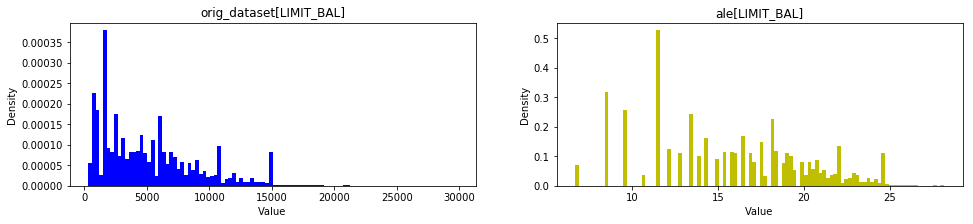

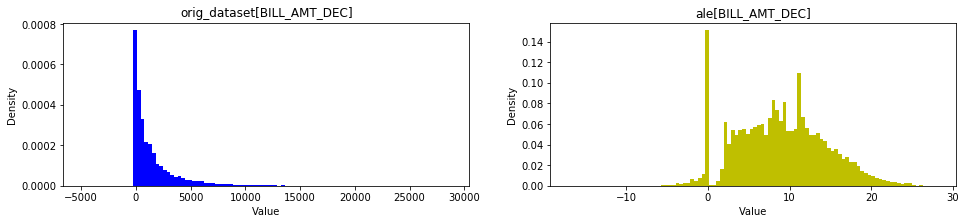

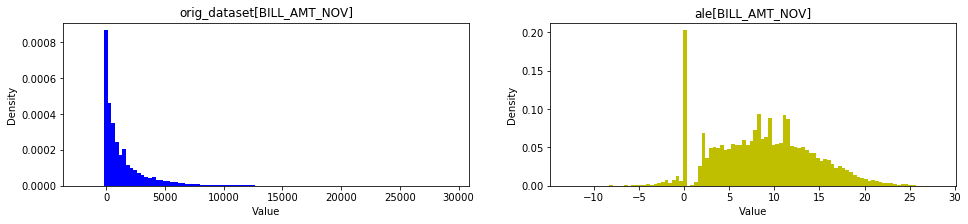

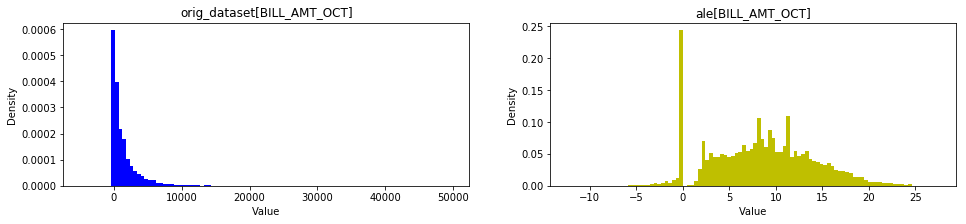

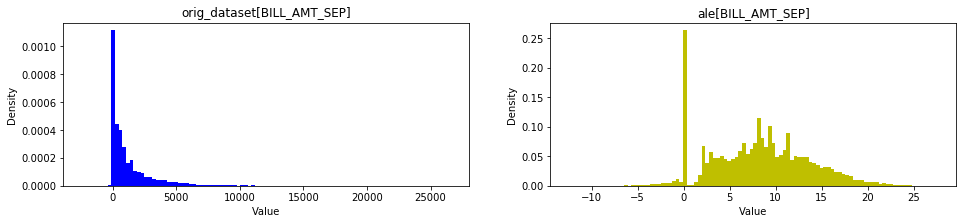

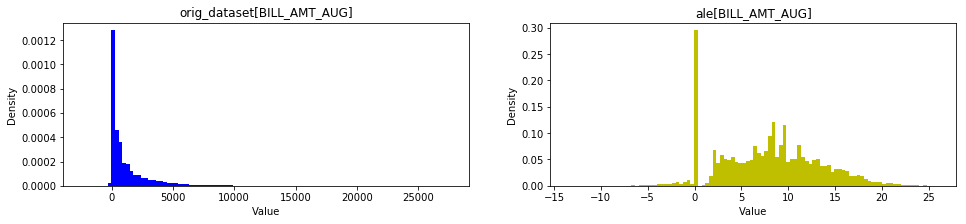

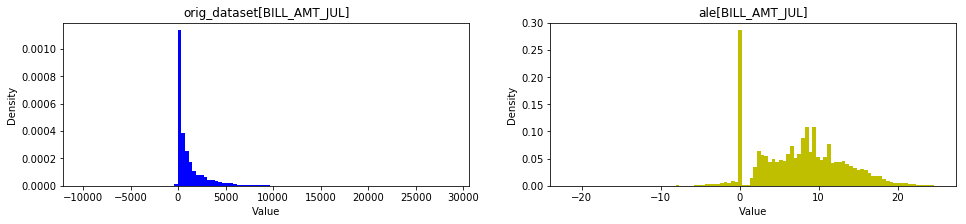

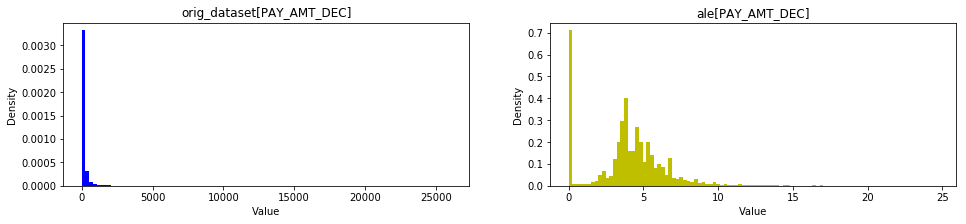

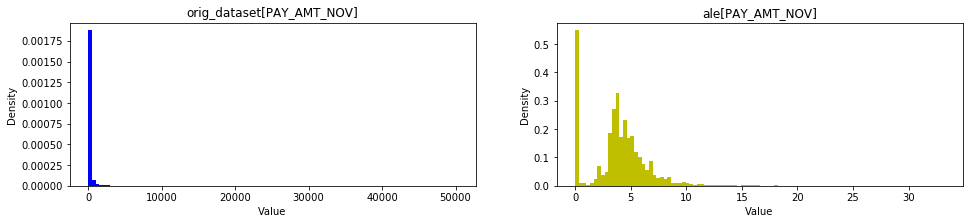

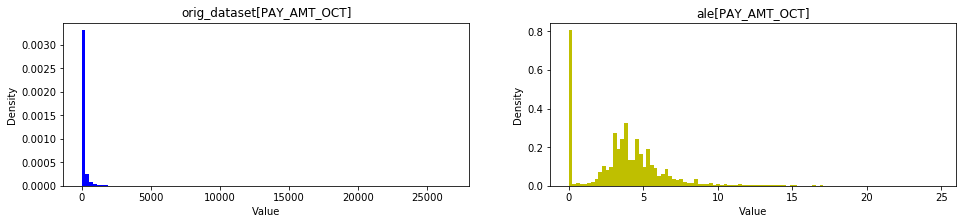

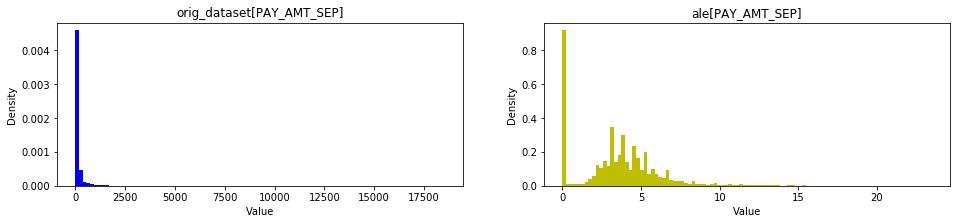

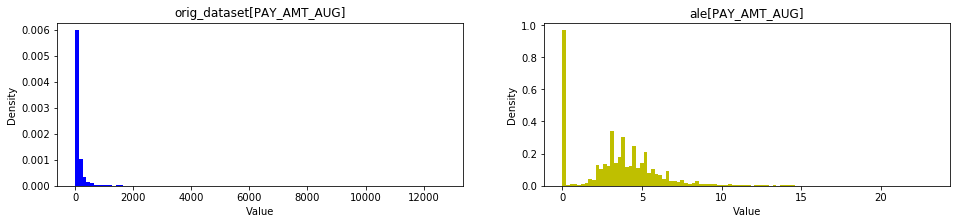

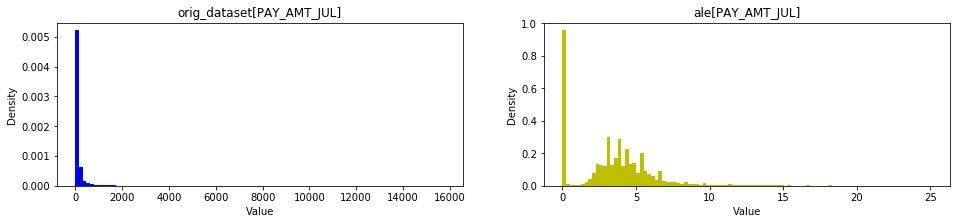

In [740]:
X, y, X_test, y_test = retrieve_dataset(name='ale')
fields = ['LIMIT_BAL',
          'BILL_AMT_DEC', 'BILL_AMT_NOV', 'BILL_AMT_OCT', 'BILL_AMT_SEP', 'BILL_AMT_AUG', 'BILL_AMT_JUL',
          'PAY_AMT_DEC', 'PAY_AMT_NOV', 'PAY_AMT_OCT', 'PAY_AMT_SEP', 'PAY_AMT_AUG', 'PAY_AMT_JUL']
for col_name in fields:
    fig, axarr = plt.subplots(1, 2, figsize=(16, 3))
    axarr[0].hist(orig_dataset[col_name], 100, normed=1, facecolor='b')
    axarr[0].set_xlabel('Value')
    axarr[0].set_ylabel('Density')
    axarr[0].set_title('orig_dataset[{}]'.format(col_name))

    axarr[1].hist(X[col_name], 100, normed=1, facecolor='y')
    axarr[1].set_xlabel('Value')
    axarr[1].set_ylabel('Density')
    axarr[1].set_title('ale[{}]'.format(col_name))

    plt.show()


In [687]:
X.describe()

,LIMIT_BAL,EDUCATION,MARRIAGE,PAY_DEC,PAY_NOV,PAY_OCT,PAY_SEP,PAY_AUG,PAY_JUL,BILL_AMT_DEC,...,LIMIT_BAL_MINUS_PAY_AMT_OCT,LIMIT_BAL_MINUS_BILL_AMT_PLUS_PAY_AMT_OCT,BILL_AMT_MINUS_PAY_AMT_NOV,LIMIT_BAL_MINUS_BILL_AMT_NOV,LIMIT_BAL_MINUS_PAY_AMT_NOV,LIMIT_BAL_MINUS_BILL_AMT_PLUS_PAY_AMT_NOV,BILL_AMT_MINUS_PAY_AMT_DEC,LIMIT_BAL_MINUS_BILL_AMT_DEC,LIMIT_BAL_MINUS_PAY_AMT_DEC,LIMIT_BAL_MINUS_BILL_AMT_PLUS_PAY_AMT_DEC
count,18012.000000,18012.000000,18012.000000,18012.000000,18012.000000,18012.000000,18012.000000,18012.000000,18012.000000,18012.000000,...,18012.000000,18012.000000,18012.000000,18012.000000,18012.000000,18012.000000,18012.000000,18012.000000,18012.000000,18012.000000
mean,15.837318,0.603192,0.504536,0.199073,0.187081,0.183816,0.178853,0.174434,0.171502,8.934725,...,15.611654,12.937787,7.107439,12.053366,15.566588,12.752355,7.394664,11.808036,15.571764,12.552053
std,4.609824,0.328353,0.449097,0.112155,0.119147,0.119544,0.117635,0.114322,0.115776,5.484973,...,4.697995,6.621087,7.260240,7.418782,4.759589,6.785965,7.169477,7.611018,4.758717,6.936145
min,6.680436,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-17.027103,...,-10.058417,-20.002809,-28.118546,-20.848831,-27.754138,-20.373002,-27.140739,-20.006137,-18.283364,-19.564710
25%,11.423385,0.500000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,4.830134,...,11.423385,8.178685,2.180522,6.907764,11.423385,7.663596,2.900529,6.483691,11.423385,7.362027
50%,16.100801,0.500000,0.100000,0.200000,0.200000,0.200000,0.200000,0.200000,0.200000,8.856074,...,15.938508,13.208269,8.200319,12.706631,15.906797,13.033011,8.319827,12.400130,15.895005,12.779214
75%,19.269712,1.000000,1.000000,0.200000,0.200000,0.200000,0.200000,0.200000,0.200000,12.645696,...,19.015347,18.142540,12.137134,18.079202,18.998271,18.139588,12.342911,18.015701,18.998271,18.133493
max,28.172490,1.000000,1.000000,1.000000,0.900000,1.000000,0.900000,0.900000,1.000000,28.132541,...,28.138579,29.263447,27.838348,28.051076,28.143285,33.452874,27.872737,28.053033,28.086873,30.909333


# Dataset Creation - ale_scaled

In [744]:
X, y, X_test, y_test = retrieve_dataset('ale')
ss = RobustScaler()
ss.fit(X)
X_scaled = pd.DataFrame(ss.transform(X), columns=X.columns, index=X.index)
X_test_scaled = pd.DataFrame(ss.transform(X_test), columns=X_test.columns, index=X_test.index)
add_dataset(X_scaled, y, X_test_scaled, y_test, 'ale_scaled')
X_scaled.head(5)

,LIMIT_BAL,EDUCATION,MARRIAGE,PAY_DEC,PAY_NOV,PAY_OCT,PAY_SEP,PAY_AUG,PAY_JUL,BILL_AMT_DEC,...,LIMIT_BAL_MINUS_PAY_AMT_OCT,LIMIT_BAL_MINUS_BILL_AMT_PLUS_PAY_AMT_OCT,BILL_AMT_MINUS_PAY_AMT_NOV,LIMIT_BAL_MINUS_BILL_AMT_NOV,LIMIT_BAL_MINUS_PAY_AMT_NOV,LIMIT_BAL_MINUS_BILL_AMT_PLUS_PAY_AMT_NOV,BILL_AMT_MINUS_PAY_AMT_DEC,LIMIT_BAL_MINUS_BILL_AMT_DEC,LIMIT_BAL_MINUS_PAY_AMT_DEC,LIMIT_BAL_MINUS_BILL_AMT_PLUS_PAY_AMT_DEC
CUST_COD,,,,,,,,,,,,,,,,,,,,,
14356766,-0.349199,0.0,0.0,1.0,2.0,2.0,2.0,2.0,-2.0,-0.499532,...,-0.339676,-0.031488,-1.091567,0.038995,-0.369813,0.034673,-0.356677,0.063305,-0.334544,0.032582
21308338,-0.979309,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.137981,...,-1.019183,-0.928558,-0.005559,-1.275832,-1.027137,-0.879032,-0.155662,-0.640799,-1.088837,-0.582783
54049646,0.179306,-0.8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.658823,...,0.193146,0.060408,0.559072,0.094748,0.189732,0.094463,0.580921,0.120076,0.196120,0.111985
10396398,-0.824073,-0.8,0.0,-1.0,-1.0,-2.0,-2.0,-2.0,-2.0,-0.786834,...,-0.830306,-0.358638,-0.823605,-0.274967,-0.827991,-0.324375,-0.594479,-0.246011,-0.826435,-0.298574
11528589,-0.158500,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.323245,...,-0.160388,0.006695,0.217493,0.004538,-0.156564,-0.009074,0.299406,-0.019505,-0.155049,-0.037662


In [689]:
X_scaled.describe().round(3)

,LIMIT_BAL,EDUCATION,MARRIAGE,PAY_DEC,PAY_NOV,PAY_OCT,PAY_SEP,PAY_AUG,PAY_JUL,BILL_AMT_DEC,...,LIMIT_BAL_MINUS_PAY_AMT_OCT,LIMIT_BAL_MINUS_BILL_AMT_PLUS_PAY_AMT_OCT,BILL_AMT_MINUS_PAY_AMT_NOV,LIMIT_BAL_MINUS_BILL_AMT_NOV,LIMIT_BAL_MINUS_PAY_AMT_NOV,LIMIT_BAL_MINUS_BILL_AMT_PLUS_PAY_AMT_NOV,BILL_AMT_MINUS_PAY_AMT_DEC,LIMIT_BAL_MINUS_BILL_AMT_DEC,LIMIT_BAL_MINUS_PAY_AMT_DEC,LIMIT_BAL_MINUS_BILL_AMT_PLUS_PAY_AMT_DEC
count,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,...,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000
mean,-0.034,0.206,0.449,-0.009,-0.129,-0.162,-0.211,-0.256,-0.285,0.010,...,-0.043,-0.027,-0.110,-0.058,-0.045,-0.027,-0.098,-0.051,-0.043,-0.021
std,0.588,0.657,0.499,1.122,1.191,1.195,1.176,1.143,1.158,0.702,...,0.619,0.665,0.729,0.664,0.628,0.648,0.759,0.660,0.628,0.644
min,-1.201,-1.000,-0.111,-2.000,-2.000,-2.000,-2.000,-2.000,-2.000,-3.312,...,-3.424,-3.333,-3.648,-3.004,-5.764,-3.189,-3.755,-2.810,-4.512,-3.003
25%,-0.596,0.000,0.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-0.515,...,-0.595,-0.505,-0.605,-0.519,-0.592,-0.513,-0.574,-0.513,-0.590,-0.503
50%,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
75%,0.404,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.485,...,0.405,0.495,0.395,0.481,0.408,0.487,0.426,0.487,0.410,0.497
max,1.539,1.000,1.000,8.000,7.000,8.000,7.000,7.000,8.000,2.466,...,1.607,1.611,1.972,1.374,1.615,1.949,2.071,1.357,1.610,1.683


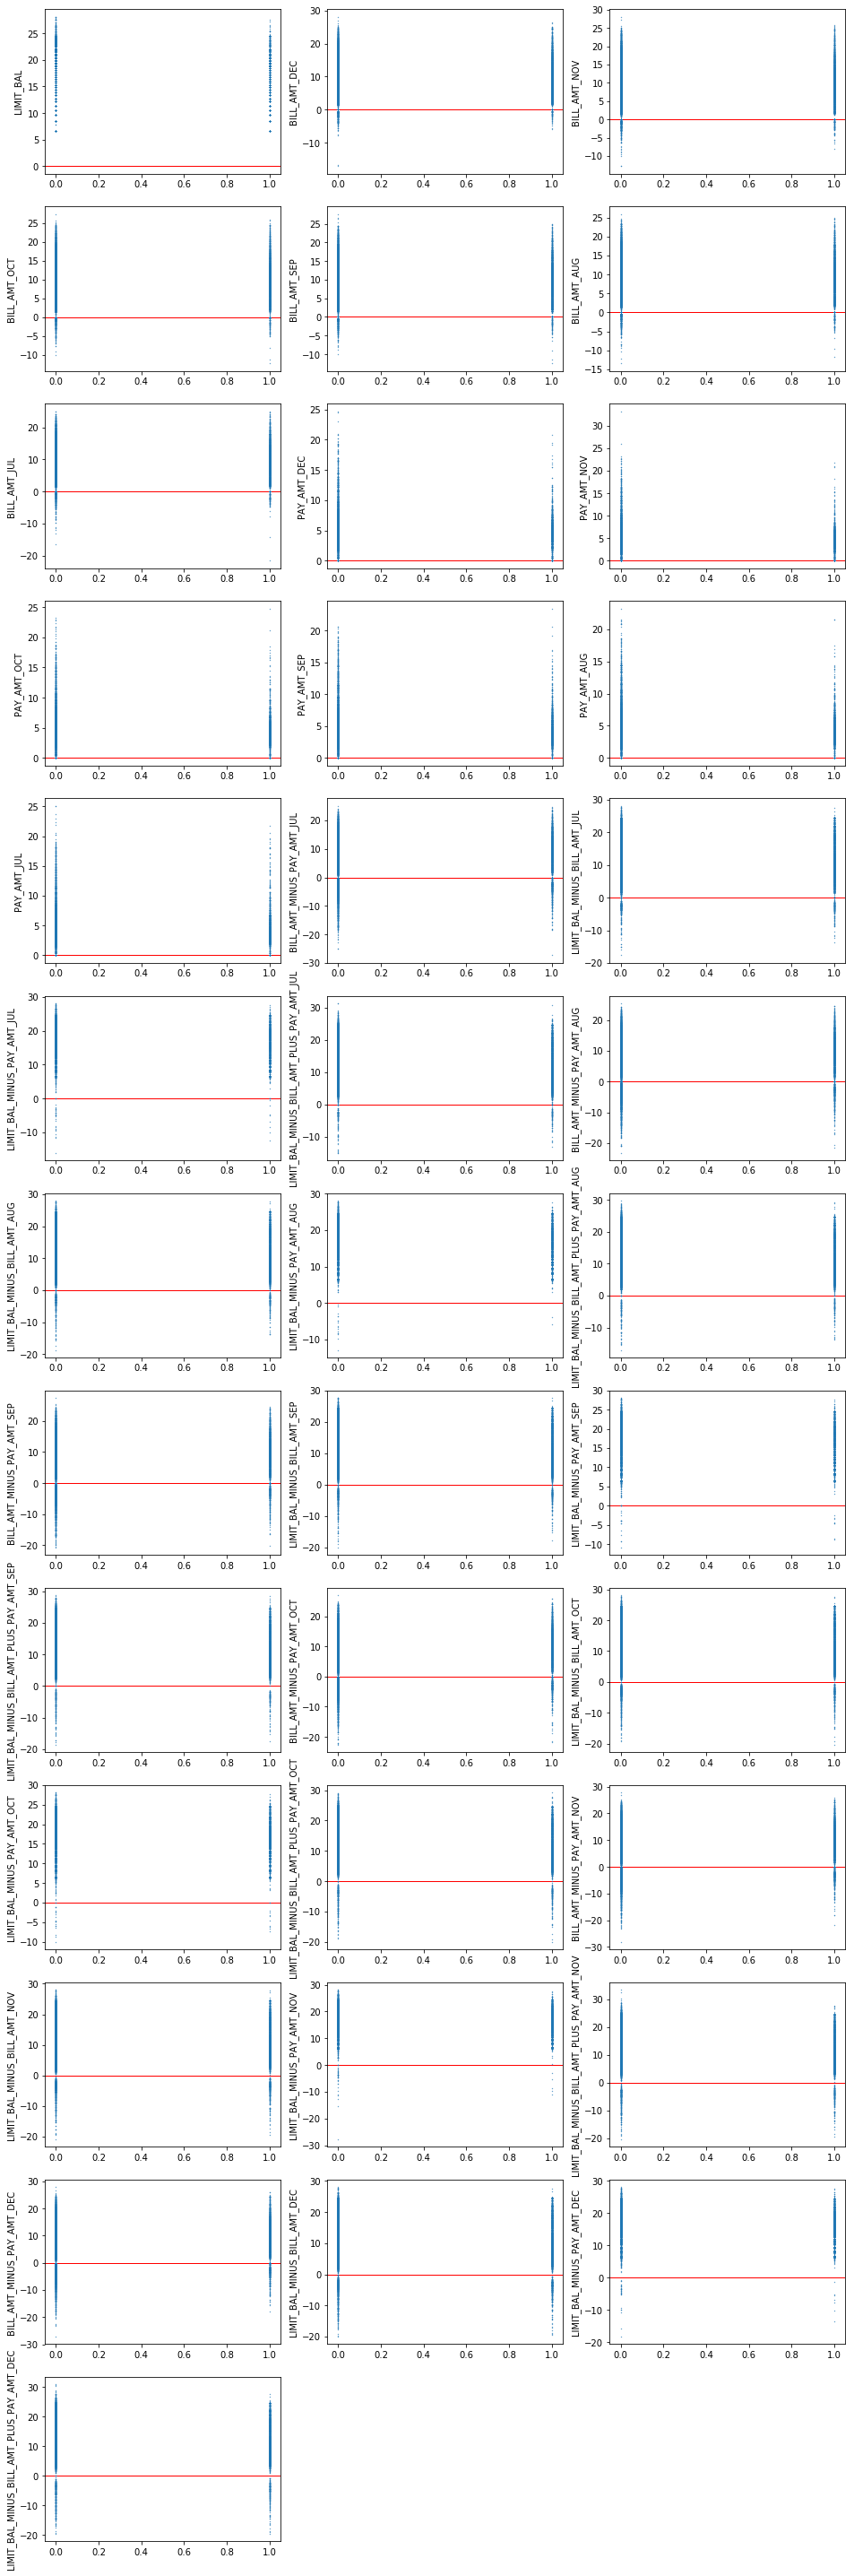

In [690]:
X, y, X_test, y_test = retrieve_dataset('ale')
fields = ['LIMIT_BAL',
          'BILL_AMT_DEC', 'BILL_AMT_NOV', 'BILL_AMT_OCT', 'BILL_AMT_SEP', 'BILL_AMT_AUG', 'BILL_AMT_JUL',
          'PAY_AMT_DEC', 'PAY_AMT_NOV', 'PAY_AMT_OCT', 'PAY_AMT_SEP', 'PAY_AMT_AUG', 'PAY_AMT_JUL',
          'BILL_AMT_MINUS_PAY_AMT_JUL', 'LIMIT_BAL_MINUS_BILL_AMT_JUL', 'LIMIT_BAL_MINUS_PAY_AMT_JUL', 
          'LIMIT_BAL_MINUS_BILL_AMT_PLUS_PAY_AMT_JUL', 'BILL_AMT_MINUS_PAY_AMT_AUG', 'LIMIT_BAL_MINUS_BILL_AMT_AUG',
          'LIMIT_BAL_MINUS_PAY_AMT_AUG', 'LIMIT_BAL_MINUS_BILL_AMT_PLUS_PAY_AMT_AUG', 'BILL_AMT_MINUS_PAY_AMT_SEP',
          'LIMIT_BAL_MINUS_BILL_AMT_SEP', 'LIMIT_BAL_MINUS_PAY_AMT_SEP', 'LIMIT_BAL_MINUS_BILL_AMT_PLUS_PAY_AMT_SEP',
          'BILL_AMT_MINUS_PAY_AMT_OCT', 'LIMIT_BAL_MINUS_BILL_AMT_OCT', 'LIMIT_BAL_MINUS_PAY_AMT_OCT',
          'LIMIT_BAL_MINUS_BILL_AMT_PLUS_PAY_AMT_OCT', 'BILL_AMT_MINUS_PAY_AMT_NOV', 'LIMIT_BAL_MINUS_BILL_AMT_NOV',
          'LIMIT_BAL_MINUS_PAY_AMT_NOV', 'LIMIT_BAL_MINUS_BILL_AMT_PLUS_PAY_AMT_NOV', 'BILL_AMT_MINUS_PAY_AMT_DEC',
          'LIMIT_BAL_MINUS_BILL_AMT_DEC', 'LIMIT_BAL_MINUS_PAY_AMT_DEC', 'LIMIT_BAL_MINUS_BILL_AMT_PLUS_PAY_AMT_DEC']
# 40 fields
i = 1
fig = plt.figure(figsize=(16, 14 * 4))
for col_name in fields:
    ax = fig.add_subplot(14, 3, i)
    i += 1
    # ax.set_xlabel('DEFAULT PAYMENT JAN')
    ax.set_ylabel(col_name)
    ax.scatter(y, X[col_name], s=0.1)
    ax.axhline(y=0, c='red', linewidth=1, zorder=0)
plt.show() 

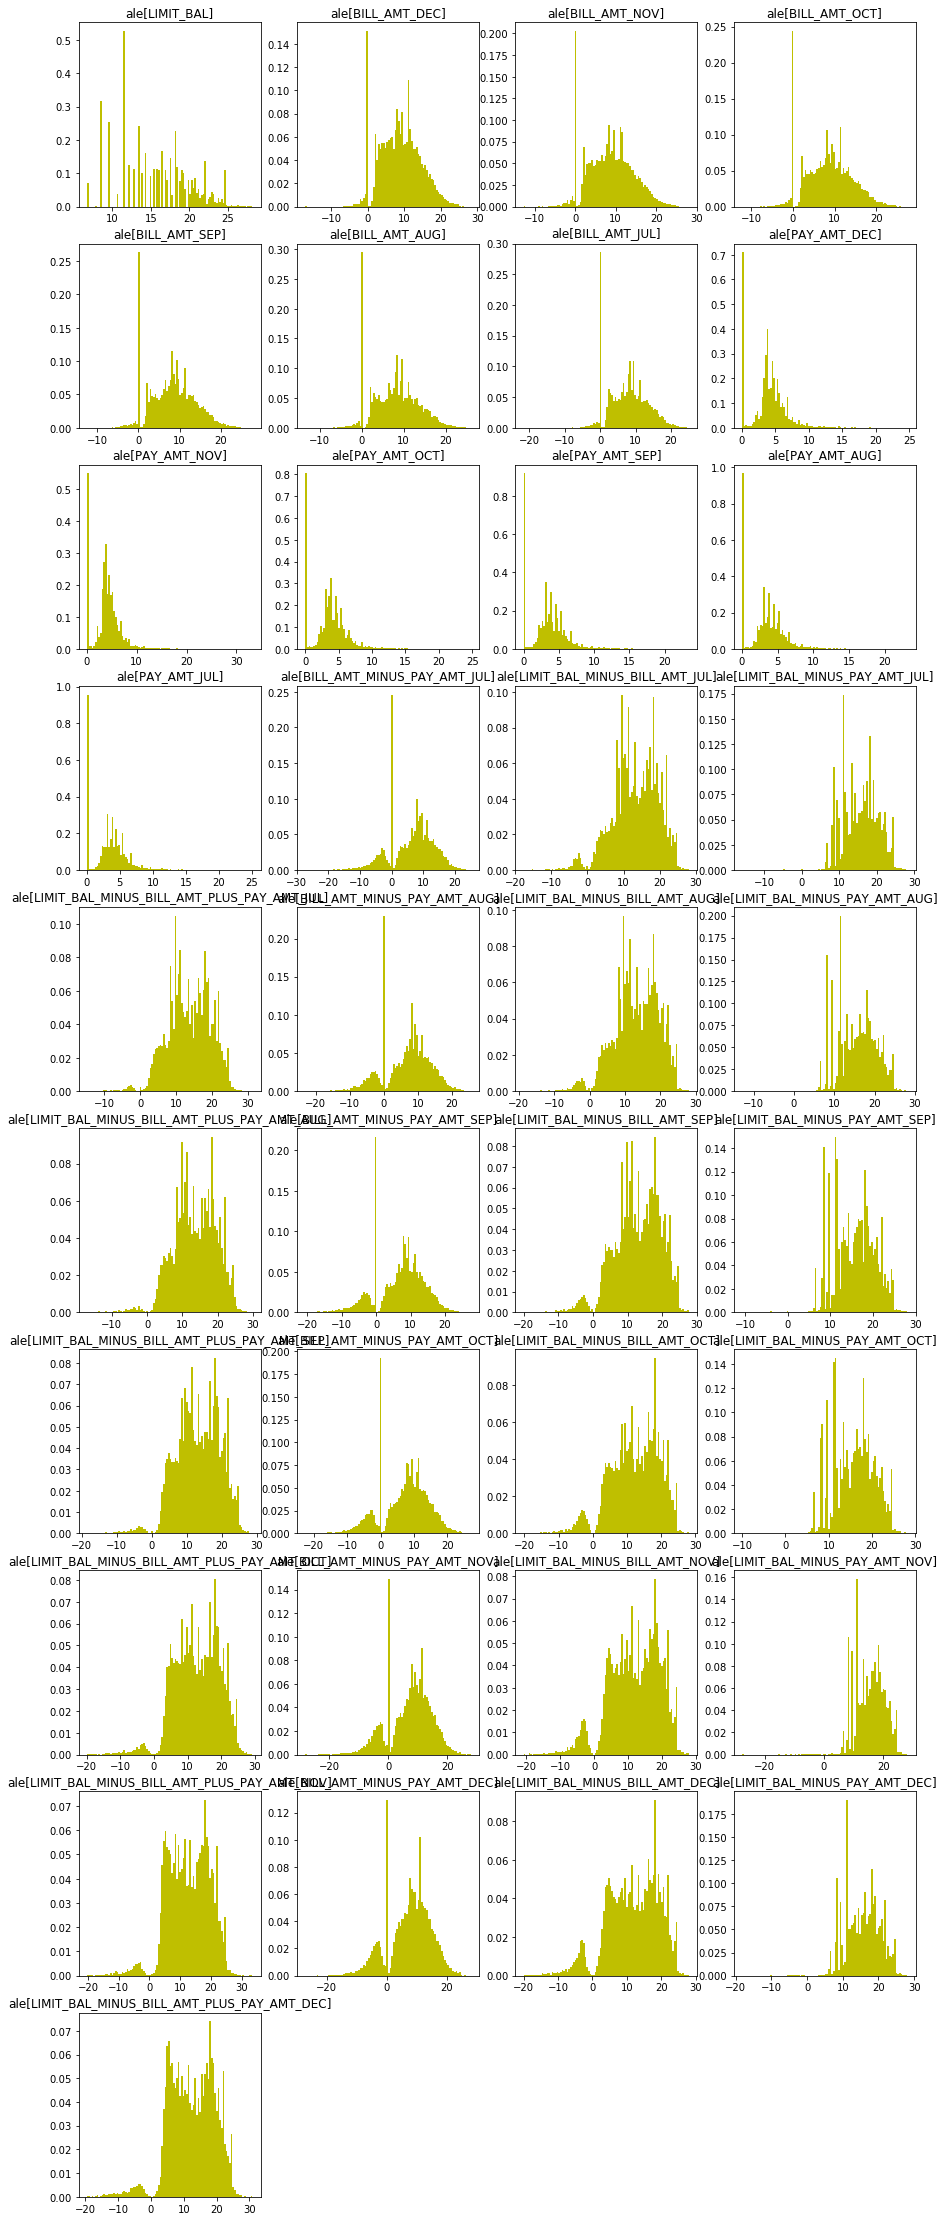

In [691]:
X, y, X_test, y_test = retrieve_dataset('ale')
fields = ['LIMIT_BAL',
          'BILL_AMT_DEC', 'BILL_AMT_NOV', 'BILL_AMT_OCT', 'BILL_AMT_SEP', 'BILL_AMT_AUG', 'BILL_AMT_JUL',
          'PAY_AMT_DEC', 'PAY_AMT_NOV', 'PAY_AMT_OCT', 'PAY_AMT_SEP', 'PAY_AMT_AUG', 'PAY_AMT_JUL',
          'BILL_AMT_MINUS_PAY_AMT_JUL', 'LIMIT_BAL_MINUS_BILL_AMT_JUL', 'LIMIT_BAL_MINUS_PAY_AMT_JUL', 
          'LIMIT_BAL_MINUS_BILL_AMT_PLUS_PAY_AMT_JUL', 'BILL_AMT_MINUS_PAY_AMT_AUG', 'LIMIT_BAL_MINUS_BILL_AMT_AUG',
          'LIMIT_BAL_MINUS_PAY_AMT_AUG', 'LIMIT_BAL_MINUS_BILL_AMT_PLUS_PAY_AMT_AUG', 'BILL_AMT_MINUS_PAY_AMT_SEP',
          'LIMIT_BAL_MINUS_BILL_AMT_SEP', 'LIMIT_BAL_MINUS_PAY_AMT_SEP', 'LIMIT_BAL_MINUS_BILL_AMT_PLUS_PAY_AMT_SEP',
          'BILL_AMT_MINUS_PAY_AMT_OCT', 'LIMIT_BAL_MINUS_BILL_AMT_OCT', 'LIMIT_BAL_MINUS_PAY_AMT_OCT',
          'LIMIT_BAL_MINUS_BILL_AMT_PLUS_PAY_AMT_OCT', 'BILL_AMT_MINUS_PAY_AMT_NOV', 'LIMIT_BAL_MINUS_BILL_AMT_NOV',
          'LIMIT_BAL_MINUS_PAY_AMT_NOV', 'LIMIT_BAL_MINUS_BILL_AMT_PLUS_PAY_AMT_NOV', 'BILL_AMT_MINUS_PAY_AMT_DEC',
          'LIMIT_BAL_MINUS_BILL_AMT_DEC', 'LIMIT_BAL_MINUS_PAY_AMT_DEC', 'LIMIT_BAL_MINUS_BILL_AMT_PLUS_PAY_AMT_DEC']
fig = plt.figure(figsize=(15,4*10))
i = 1
for col_name in fields:
    ax = fig.add_subplot(10, 4, i)
    i += 1
    ax.set_title('ale[{}]'.format(col_name))
    ax.hist(X[col_name], 100, normed=1, facecolor='y')
plt.show()

# Preliminary Prediction Tests

In [692]:
X, y, X_test, y_test = retrieve_dataset(name='orig')

y_pred = X['PAY_AMT_DEC'] < X['BILL_AMT_DEC']
print(confusion_matrix(y, y_pred))
print(f1_score(y, y_pred))

y_pred = (X['PAY_DEC'] > 0)
print(confusion_matrix(y, y_pred))
print(f1_score(y, y_pred))

y_pred = (X['PAY_DEC'] > 0)
y_pred &= (X['PAY_AMT_DEC'] < X['BILL_AMT_DEC'] + 1000)
y_pred &= (X['PAY_AMT_NOV'] < X['BILL_AMT_NOV'] + 1000)
y_pred &= (X['PAY_AMT_OCT'] < X['BILL_AMT_OCT'] + 1000)
print(confusion_matrix(y, y_pred))
print(f1_score(y, y_pred))

y_pred = (X['PAY_DEC'] > 0)
y_pred &= (X['PAY_NOV'] > 0)
y_pred &= (X['PAY_OCT'] > 0)
print(confusion_matrix(y, y_pred))
print(f1_score(y, y_pred))

[[ 3109 10921]
 [  735  3247]]
0.357796143251
[[11985  2045]
 [ 1913  2069]]
0.511116600791
[[12057  1973]
 [ 1934  2048]]
0.511808071973
[[13432   598]
 [ 2931  1051]]
0.373290712129


# PAY_AMT vs Month, BILL_AMT vs Month

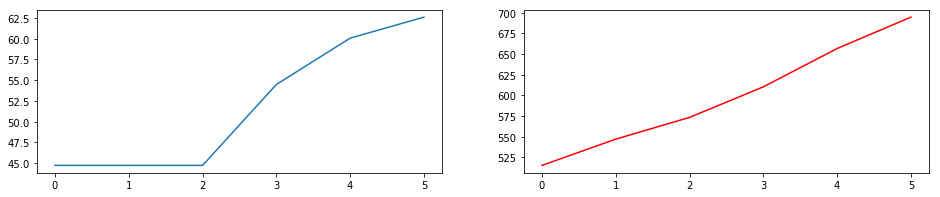

In [693]:
X, y, X_test, y_test = retrieve_dataset(name='orig')
months = ['JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']

m = [X['PAY_AMT_{}'.format(month)].median() for month in months]

fig = plt.figure(figsize=(16, 3))
ax = fig.add_subplot(1, 2, 1)
ax.plot(m)
m = [X['BILL_AMT_{}'.format(month)].median() for month in months]
ax = fig.add_subplot(1, 2, 2)
ax.plot(m, c='r')

plt.show()


# Variables distribution

# 2D PCA - ale_scaled

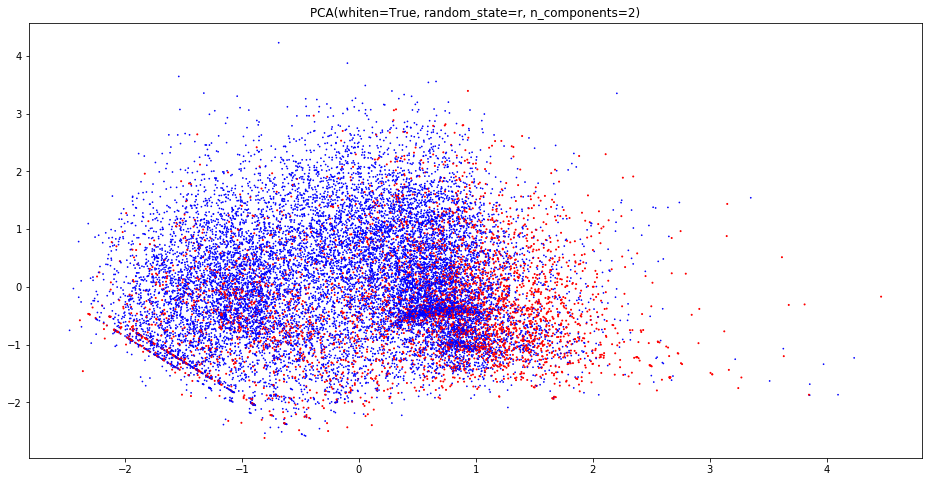

In [745]:
X, y, X_test, y_test = retrieve_dataset('ale_scaled')

colors = {0: 'b', 1: 'r', 2: 'y'}
sizes = {0: 0.5, 1: 1}

c = y.apply(lambda x: colors[x])
s = y.apply(lambda x: sizes[x])

pca = PCA(whiten=False, random_state=r, n_components=2)
pca.fit(X)

plt.figure(figsize=(16,8))
df = pd.DataFrame(pca.transform(X), index=X.index)
plt.scatter(df[0], df[1], c=c, s=s)
plt.title('PCA(whiten=True, random_state=r, n_components=2)')
plt.show()

# 3D PCA - ale_scaled

PCA(whiten=True, random_state=r, n_components=3)


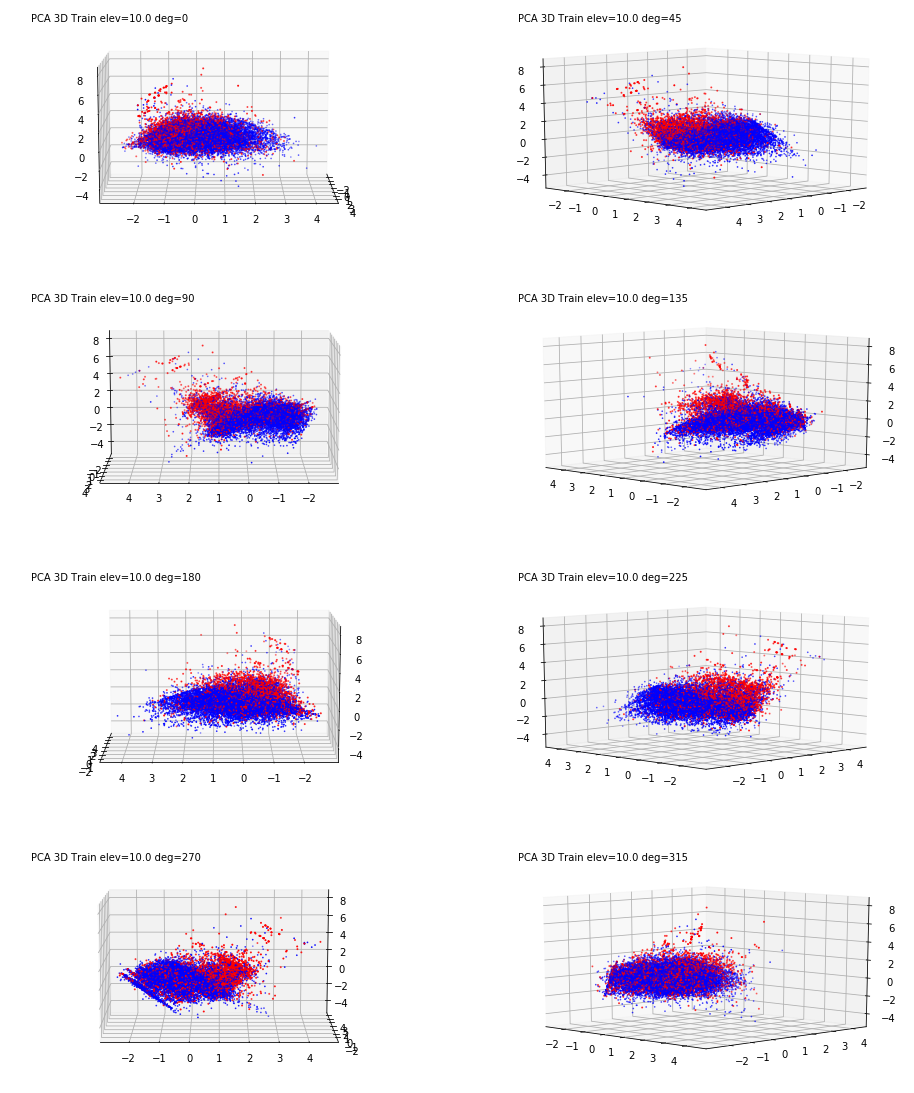

In [746]:
X, y, X_test, y_test = retrieve_dataset('ale_scaled')
colors = {0: 'b', 1: 'r', 2: 'y'}
sizes = {0: 0.5, 1: 1}
c = y.apply(lambda x: colors[x])
s = y.apply(lambda x: sizes[x])
         
print('PCA(whiten=True, random_state=r, n_components=3)')
pca = PCA(whiten=False, random_state=r, n_components=3)
pca.fit(X)
df = pd.DataFrame(pca.transform(X), index=X.index)
# kmeans = KMeans(n_clusters=5, random_state=r, copy_x=True, n_jobs=-1).fit(df)
# c = list(map(lambda x: 'C{}'.format(x), list(kmeans.predict(df))))
fig = plt.figure(figsize=(16, 6 * 5))
for ii in np.arange(0, 360, 45):
    ax = fig.add_subplot(6, 2, ii / 45 + 1, projection='3d')
    ax.text2D(0.05, 0.95, 'PCA 3D Train elev={} deg={}'.format(10., ii), transform=ax.transAxes)
    ax.view_init(elev=10., azim=ii)
    ax.scatter(df[0], df[1], df[2], c=c, s=s)
plt.show()

# PCA - tresh = 0.99

Starting PCA
cumsum_tresh = 0.8, n_components = 6
cumsum_tresh = 0.85, n_components = 9
cumsum_tresh = 0.9, n_components = 11
cumsum_tresh = 0.95, n_components = 16
cumsum_tresh = 0.97, n_components = 19
cumsum_tresh = 0.99, n_components = 25


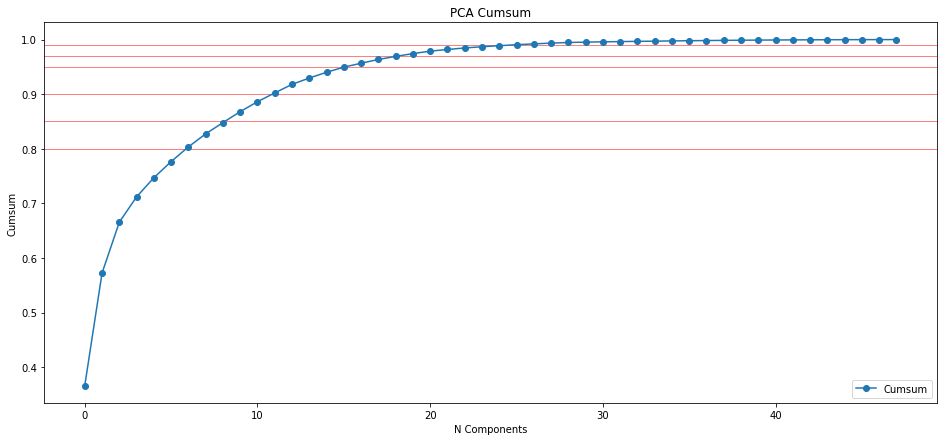

Selecting tresh = 0.99 -> n_components = 25


In [806]:
X, y, X_test, y_test = retrieve_dataset('ale_scaled')

print('Starting PCA')
pca = PCA(whiten=False, random_state=r)
pca.fit(X)

cumsum = sorted(list(pca.explained_variance_ratio_.cumsum()))

def find_cumsum_tresh(cumsum, cumsum_tresh):
    for i in np.arange(0, len(cumsum)):
        if cumsum[i] >= cumsum_tresh:
            break
    return i

plt.figure(figsize=(16,7))
plt.plot(cumsum, label='Cumsum', marker='o')
plt.xlabel('N Components')
plt.ylabel('Cumsum')
plt.title('PCA Cumsum')
plt.legend(loc='best')

for i in [0.8, 0.85, 0.9, 0.95, 0.97, 0.99]:
    n_components = find_cumsum_tresh(cumsum, i)
    print('cumsum_tresh = {}, n_components = {}'.format(i, n_components))
    plt.axhline(y=i, c='red', linewidth=0.5, zorder=0)

plt.show()

tresh = 0.99

n_components = find_cumsum_tresh(cumsum, tresh)
print('Selecting tresh = {} -> n_components = {}'.format(tresh, n_components))
pca = PCA(whiten=False, random_state=r, n_components=n_components)
pca.fit(X)
X_pca = pd.DataFrame(pca.transform(X), index=X.index)
X_pca_test = pd.DataFrame(pca.transform(X_test), index=X_test.index)

add_dataset(X_pca, y, X_pca_test, y_test, 'ale_pca')

In [807]:
X, y, X_test, y_test = retrieve_dataset('ale_pca')
X.head(5)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
CUST_COD,,,,,,,,,,,,,,,,,,,,,
14356766,1.385830,-2.578572,3.414985,0.546021,-0.501178,2.087263,-1.534710,-1.124562,-0.537276,0.270302,...,1.017545,-0.608604,0.795365,0.140719,-1.271939,-0.190872,-0.018257,-0.119036,0.094508,0.538458
21308338,3.299621,-2.379292,-2.283083,0.863022,0.311324,-0.177632,0.209884,-0.014650,-1.380739,-0.062866,...,-0.289758,-0.193652,0.152951,-0.072867,0.107028,-0.432214,0.216284,-0.103790,-0.104139,0.124148
54049646,1.044987,2.323419,-0.119122,-0.714684,-0.190543,0.121630,0.466659,0.374471,1.231513,0.081958,...,-0.288432,-0.408207,-0.282115,0.098177,-0.078885,0.169336,0.042307,-0.021091,0.067771,0.097589
10396398,-2.536236,-5.357546,-1.893013,-1.128933,-0.298239,0.035674,0.444082,0.104018,0.989320,0.159337,...,-0.486871,-0.396452,0.070052,0.999786,-0.022541,0.037059,0.065187,0.180754,-0.112942,0.017583
11528589,0.869951,0.837237,-0.144550,0.005081,-0.112195,-0.181078,0.038645,0.024615,0.659005,0.250571,...,-0.151167,-0.419072,-0.364763,-0.401661,0.009299,0.178867,-0.016691,0.044026,0.038593,0.028311


In [808]:
X.describe().round(3)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
count,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,...,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000
mean,0.000,0.000,-0.000,-0.000,0.000,0.000,0.000,-0.000,-0.000,-0.000,...,0.000,-0.000,0.000,0.000,-0.000,-0.000,0.000,-0.000,0.000,0.000
std,3.315,2.486,1.671,1.180,1.025,0.941,0.899,0.846,0.785,0.777,...,0.530,0.464,0.453,0.414,0.388,0.369,0.302,0.289,0.258,0.240
min,-8.207,-6.508,-7.611,-5.490,-6.320,-6.100,-4.751,-5.968,-1.631,-4.637,...,-2.731,-1.938,-2.617,-1.091,-2.361,-3.168,-2.278,-1.842,-1.809,-2.019
25%,-2.799,-1.831,-1.131,-0.776,-0.372,-0.384,-0.493,-0.312,-0.620,-0.431,...,-0.295,-0.310,-0.273,-0.326,-0.125,-0.161,-0.127,-0.133,-0.117,-0.100
50%,0.532,-0.312,-0.163,-0.068,-0.061,0.017,0.157,0.051,-0.083,0.061,...,-0.038,-0.051,-0.052,0.044,-0.017,0.052,-0.002,-0.013,0.000,0.007
75%,2.526,1.666,0.936,0.706,0.360,0.402,0.505,0.280,0.542,0.325,...,0.274,0.249,0.245,0.254,0.123,0.206,0.133,0.127,0.121,0.102
max,14.803,10.507,13.326,8.957,8.825,6.932,5.036,6.304,3.175,5.846,...,3.182,3.653,3.093,1.586,2.635,3.452,3.048,3.182,2.115,2.272


# CV and scoring functions

In [753]:
def cost_matrix(y, y_pred):
    cm = confusion_matrix(y, y_pred)
    # first index true
    # second index predicted
    return cm[0][0] * 0 + cm[0][1] * 1 + cm[1][0] * 5 + cm[1][1] * 0

def cv_clf(clf, X, y, y_pred, X_test, y_test, y_pred_test):
    scores_stkfold = cross_val_score(clf, X, y, scoring='f1', cv=cv)
    f1_cv_mean = scores_stkfold.mean()
    f1_cv_std = scores_stkfold.std()
    f1_train = f1_score(y, y_pred)  
    f1_test = f1_score(y_test, y_pred_test)
    print('f1_train = {:.3f}\t f1_cv = {:.3f} ± {:.3f}\nf1_test = {:.3f}'.format(f1_train, f1_cv_mean, f1_cv_std, f1_test))
    # cost_train = cost_matrix(y, y_pred)
    # cost_test = cost_matrix(y_test, y_pred_test)
    # print('cost_train = {}\ncost_test = {}'.format(format(cost_train, ','), format(cost_test, ',')))
    cm_train = confusion_matrix(y, y_pred)
    cm_test = confusion_matrix(y_test, y_pred_test)
    print('cm_train = \n{}\ncm_test = \n{}'.format(cm_train, cm_test))

def fit_and_score(clf, name):
    print('Evaluating on ' + name + ' dataset')
    X, y, X_test, y_test = retrieve_dataset(name)
    clf.fit(X, y)
    y_pred = clf.predict(X)
    y_pred_test = clf.predict(X_test)
    cv_clf(clf, X, y, y_pred, X_test, y_test, y_pred_test)
    return (y_pred, y_pred_test)

cv = StratifiedKFold(n_splits=10, random_state=r, shuffle=True)    
ms = make_scorer(cost_matrix, greater_is_better=False)

# ROC curve function

In [772]:
def plot_roc_curve(clf, X_test, y_test):
    y_score = clf.decision_function(X_test)
    # Compute ROC curve and ROC area for each class
    fpr, tpr, t = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    t_sigm = 1 / (1 + np.exp(-t))

    i = sum(t < 0.5 for t in t_sigm)
    
    plt.figure(figsize=(16,7))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.plot(fpr[i], tpr[i], 'ro')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

# Grid Search CV function

In [755]:
def grid_search_cv(parameters, clf, n_folds=5, dataset_name='ale', scoring='f1'):
    cv=StratifiedKFold(n_splits=5, random_state=r, shuffle=True)
    n_jobs = -1
    if scoring == ms:
        n_jobs = 1
    gscv = GridSearchCV(estimator=clf, param_grid=parameters, n_jobs=n_jobs, cv=cv, scoring=scoring)
    X, y, X_test, y_test = retrieve_dataset(dataset_name)
    gscv.fit(X, y)
    print('GridSearchCV done on: ' + dataset_name)
    print(gscv.best_params_)
    print(scoring + ' = ' + str(gscv.best_score_))
    if len(parameters) == 1:
        plt.figure(1)
        if scoring == ms:
            scoring = 'Cost'
        param_name = list(parameters.keys())[0]
        if param_name == 'C':
            plt.semilogx(parameters[param_name], gscv.cv_results_['mean_test_score'], label=scoring, marker='o')
        else:
            plt.plot(parameters[param_name], gscv.cv_results_['mean_test_score'], label=scoring, marker='o')
        plt.xlabel(param_name)
        plt.ylabel(scoring)
        plt.title('CV ' + scoring)
        plt.legend(loc='best')
        plt.show()

# Level 1 algorithms - Learning from features

In [873]:
X_meta = pd.DataFrame()
X_meta_test = pd.DataFrame()

# Level 1 - Dummy Classifier
- All datasets: f1_cv = 0.217 ± 0.018

In [875]:
clf = DummyClassifier(random_state=r)
y_pred, y_pred_test = fit_and_score(clf, 'baseline')

Evaluating on baseline dataset
f1_train = 0.221	 f1_cv = 0.217 ± 0.018
f1_test = 0.225
cm_train = 
[[10932  3098]
 [ 3104   878]]
cm_test = 
[[5369 1541]
 [1519  443]]


# Level 1 - TOO SLOW, OVERFITS Level 2 - Support Vector Classifier
- ale_pca: f1_cv = 0.351 ± 0.026

In [24]:
clf = SVC(random_state=r, C=1, class_weight='balanced')
y_pred, y_pred_test = fit_and_score(clf, 'ale_pca')
X_meta['SVC_ale_pca'] = y_pred
X_meta_test['SVC_ale_pca'] = y_pred_test

Evaluating on ale_pca dataset
f1_train = 0.828	 f1_cv = 0.351 ± 0.026
f1_test = 0.354
cm_train = 
[[12612  1418]
 [  170  3812]]
cm_test = 
[[5933  977]
 [1329  633]]


# Level 1 - Decision Tree Classifier
- baseline: f1_cv = 0.533 ± 0.021

In [876]:
clf = DecisionTreeClassifier(random_state=r, max_depth=4, class_weight='balanced')
# grid_search_cv(parameters={'max_depth': np.arange(1,10)}, clf=clf, scoring='f1', dataset_name='baseline')
y_pred, y_pred_test = fit_and_score(clf, 'baseline')

X_meta['DTC_baseline'] = y_pred
X_meta_test['DTC_baseline'] = y_pred_test

Evaluating on baseline dataset
f1_train = 0.534	 f1_cv = 0.533 ± 0.021
f1_test = 0.527
cm_train = 
[[11562  2468]
 [ 1631  2351]]
cm_test = 
[[5701 1209]
 [ 828 1134]]


# Level 1 - Gaussian Naive Bayes
- baseline: f1_cv = 0.521 ± 0.014

In [877]:
# No random_state
# The priors are set based on class distribution in the dataset
# No CV needed
clf = GaussianNB()
#fit_and_score(clf, 'ale')
y_meta, y_meta_test = fit_and_score(clf, 'baseline')
X_meta['GNB_baseline'] = y_meta
X_meta_test['GNB_baseline'] = y_meta_test

Evaluating on baseline dataset
f1_train = 0.521	 f1_cv = 0.521 ± 0.014
f1_test = 0.528
cm_train = 
[[11529  2501]
 [ 1700  2282]]
cm_test = 
[[5687 1223]
 [ 821 1141]]


# Level 1 - Random Forest Classifier
- baseline: f1_cv = 0.533 ± 0.026

In [878]:
clf = RandomForestClassifier(random_state=r,
                             #n_estimators=50,
                             class_weight='balanced',
                             max_depth=3,
                             n_jobs=-1,
                             #bootstrap=False
                            )
# TOO SLOW
# grid_search_cv(parameters={'n_estimators': [100, 250, 500, 1000, 2000]}, n_folds=3, clf=clf, scoring='f1', dataset_name='ale')
y_meta, y_meta_pred = fit_and_score(clf, 'baseline')
X_meta['RFC_baseline'] = y_meta
X_meta_test['RFC_baseline'] = y_meta_pred

Evaluating on baseline dataset
f1_train = 0.535	 f1_cv = 0.533 ± 0.026
f1_test = 0.530
cm_train = 
[[11726  2304]
 [ 1686  2296]]
cm_test = 
[[5814 1096]
 [ 860 1102]]


# Level 1 - OVERFITS Level 2 - K Neighbors Classifier
- baseline_scaled: f1_cv = 0.442 ± 0.024

In [851]:
clf = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='kd_tree', n_jobs=-1)
#grid_search_cv(parameters={'n_neighbors': np.arange(1,5), 'algorithm': ['ball_tree', 'kd_tree']}, clf=clf, scoring='f1', dataset_name='ale_pca')
y_meta, y_meta_test = fit_and_score(clf, 'baseline_scaled')
X_meta['KNNC_baseline_scaled'] = y_meta
X_meta_test['KNNC_baseline_scaled'] = y_meta_test

Evaluating on baseline_scaled dataset
f1_train = 0.568	 f1_cv = 0.442 ± 0.024
f1_test = 0.425
cm_train = 
[[13325   705]
 [ 2124  1858]]
cm_test = 
[[6319  591]
 [1273  689]]


# Level 1 - Multi Layer Perceptron Classifier
- ale: f1_cv = 0.525 ± 0.025 (24,12,8,4,2)

In [879]:
clf = MLPClassifier(hidden_layer_sizes=(24,12,8,4,2),
                    solver='adam',
                    activation='logistic',
                    batch_size=500,
                    validation_fraction=0.5,
                    random_state=r,
                    verbose=False)
y_meta, y_meta_test = fit_and_score(clf, 'baseline_scaled')
X_meta['MLPC_baseline_scaled'] = y_meta
X_meta_test['MLPC_baseline_scaled'] = y_meta_test

Evaluating on baseline_scaled dataset
f1_train = 0.529	 f1_cv = 0.525 ± 0.025
f1_test = 0.523
cm_train = 
[[12625  1405]
 [ 2044  1938]]
cm_test = 
[[6217  693]
 [1021  941]]


# Level 1 - Logistic Regression
- ale_oca: f1_cv = 0.509 ± 0.017

In [880]:
clf = LogisticRegression(penalty='l2', C=1, class_weight='balanced', fit_intercept=True, random_state=r, n_jobs=-1)
# grid_search_cv(parameters={'C': [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e2, 1e3, 1e4]}, clf=clf, scoring='f1', dataset_name='ale_pca')
y_meta, y_meta_test = fit_and_score(clf, 'ale_pca')
X_meta['LR_ale_pca'] = y_meta
X_meta_test['LR_ale_pca'] = y_meta_test

Evaluating on ale_pca dataset
f1_train = 0.512	 f1_cv = 0.509 ± 0.017
f1_test = 0.512
cm_train = 
[[10614  3416]
 [ 1435  2547]]
cm_test = 
[[5239 1671]
 [ 711 1251]]


[[ 0.16431618 -0.21184447  0.33922515 -0.14472162 -0.03778653 -0.00860226
  -0.08939195 -0.03707121  0.1116419  -0.10635105  0.24332631  0.14539492
   0.23538016  0.25088952  0.00493418  0.03194996  0.33132634  0.26339894
  -0.13993665  0.01488282 -0.02115731 -0.11880488 -0.03223747 -0.09679657
  -0.0624566 ]]


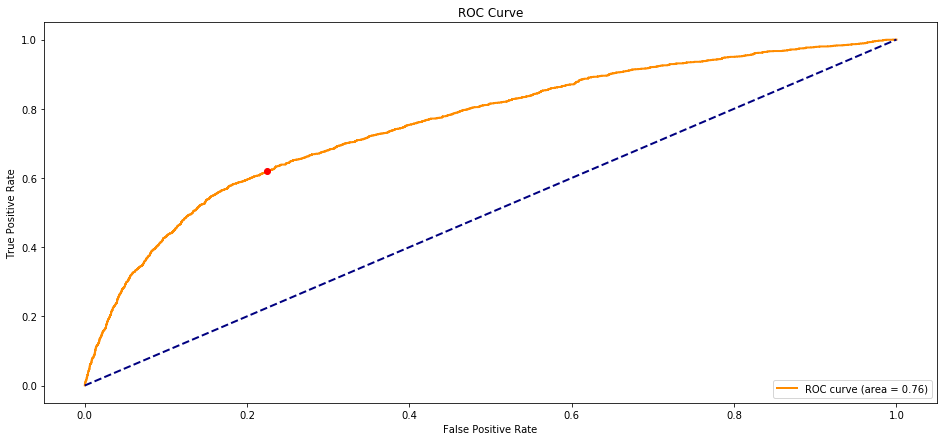

In [881]:
X, y, X_test, y_test = retrieve_dataset('ale_pca')
clf.fit(X, y)
print(clf.coef_)
plot_roc_curve(clf, X_test, y_test)

# Level 1 - XGBClassifier
- ale: f1_cv = 0.548 ± 0.021

In [882]:
# clf = XGBClassifier(seed=r, scale_pos_weight=3,
#                     learning_rate=0.1, n_estimators=100, 
#                     max_depth=3, min_child_weight=1,
#                     gamma=0.2, colsample_bytree=0.8, subsample=0.6)
clf = XGBClassifier(seed=r,
                    scale_pos_weight=3,
                    learning_rate=0.1
                   )
# grid_search_cv(parameters={'colsample_bytree':[0.2,0.5,0.8]}, clf=clf, scoring='f1', dataset_name='baseline')
y_meta, y_meta_test = fit_and_score(clf, 'ale')

X_meta['XGB_ale'] = y_meta
X_meta_test['XGB_ale'] = y_meta_test

Evaluating on ale dataset
f1_train = 0.572	 f1_cv = 0.548 ± 0.021
f1_test = 0.541
cm_train = 
[[11957  2073]
 [ 1554  2428]]
cm_test = 
[[5831 1079]
 [ 834 1128]]


# Build meta dataset for Level 2

In [883]:
X, y, X_test, y_test = retrieve_dataset('orig')
add_dataset(X_meta, y, X_meta_test, y_test, 'meta')
X, y, X_test, y_test = retrieve_dataset('meta')
X.head(20)

,DTC_baseline,GNB_baseline,RFC_baseline,MLPC_baseline_scaled,LR_ale_pca,XGB_ale
0,1,1,1,1,1,1
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0
5,0,0,0,0,1,0
6,0,0,0,0,0,0
7,0,0,0,0,0,0
8,0,0,0,0,0,0
9,0,0,0,0,0,0


In [884]:
X_test.head(20)

,DTC_baseline,GNB_baseline,RFC_baseline,MLPC_baseline_scaled,LR_ale_pca,XGB_ale
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,1,0
5,0,0,0,0,1,0
6,0,0,0,0,0,0
7,0,0,0,0,0,0
8,0,0,0,0,0,0
9,1,1,1,1,1,0


# Learning from predictions - Level 2 algorithms

# Level 2 - XGBClassifier
- f1_cv = 0.573 ± 0.020
- f1_test = 0.542

In [885]:
clf = XGBClassifier(seed=r, scale_pos_weight=3)
fit_and_score(clf, 'meta')

Evaluating on meta dataset
f1_train = 0.573	 f1_cv = 0.573 ± 0.020
f1_test = 0.542
cm_train = 
[[11956  2074]
 [ 1548  2434]]
cm_test = 
[[5835 1075]
 [ 833 1129]]


(array([1, 0, 0, ..., 0, 0, 0], dtype=int64),
 array([0, 0, 0, ..., 0, 0, 0], dtype=int64))

# Level 2 - Majority Voting

In [903]:
X, y, X_test, y_test = retrieve_dataset('meta')
y_pred = (X.sum(axis=1) >= 3).apply(lambda x: 1 if x else 0)
y_pred_test = (X_test.sum(axis=1) >= 3).apply(lambda x: 1 if x else 0)

print(confusion_matrix(y_test, y_pred_test))
print(f1_score(y_test, y_pred_test))

[[5773 1137]
 [ 817 1145]]
0.53958529689


# Level 2 - Logistic Regression
- f1_cv = 0.570 ± 0.020
- f1_test = 0.542

Evaluating on meta dataset
f1_train = 0.570	 f1_cv = 0.570 ± 0.020
f1_test = 0.542
cm_train = 
[[11887  2143]
 [ 1540  2442]]
cm_test = 
[[5807 1103]
 [ 824 1138]]
Index(['DTC_baseline', 'GNB_baseline', 'RFC_baseline', 'MLPC_baseline_scaled',
       'LR_ale_pca', 'XGB_ale'],
      dtype='object')
[[ 0.15693872  0.16469937 -0.37714521  0.6954052   0.33655813  1.52195352]]


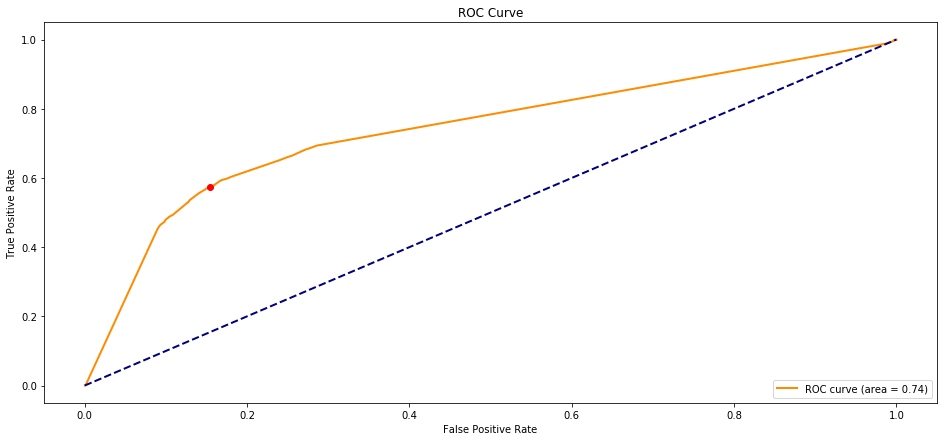

In [897]:
# parameters = {'C': [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e2, 1e3, 1e4]}
clf = LogisticRegression(penalty='l2', C=1, class_weight='balanced', fit_intercept=True, random_state=r, n_jobs=-1)
#grid_search_cv(parameters=parameters, clf=clf, scoring='f1', dataset_name='meta')
fit_and_score(clf, 'meta')
X, y, X_test, y_test = retrieve_dataset('meta')
clf.fit(X, y)
print(X_meta.columns)
print(clf.coef_)
plot_roc_curve(clf, X_test, y_test)

# Level 2 - Gaussian Naive Bayes
- f1_cv = 0.546 ± 0.020
- f1_test = 0.540

In [898]:
clf = GaussianNB()
fit_and_score(clf, 'meta')

Evaluating on meta dataset
f1_train = 0.546	 f1_cv = 0.546 ± 0.020
f1_test = 0.540
cm_train = 
[[11701  2329]
 [ 1615  2367]]
cm_test = 
[[5772 1138]
 [ 816 1146]]


(array([1, 0, 0, ..., 0, 0, 0], dtype=int64),
 array([0, 0, 0, ..., 0, 0, 0], dtype=int64))

# Level 2 - Decision Tree Classifier
- f1_cv = 0.572 ± 0.020
- f1_test = 0.541

In [899]:
clf = DecisionTreeClassifier(random_state=r, max_depth=1, class_weight='balanced')
fit_and_score(clf, 'meta')

Evaluating on meta dataset
f1_train = 0.572	 f1_cv = 0.572 ± 0.020
f1_test = 0.541
cm_train = 
[[11957  2073]
 [ 1554  2428]]
cm_test = 
[[5831 1079]
 [ 834 1128]]


(array([1, 0, 0, ..., 0, 0, 0], dtype=int64),
 array([0, 0, 0, ..., 0, 0, 0], dtype=int64))